# Figure 1B,C: optogenetically-induced synthetic RhoA wave

## Definitions

In [3]:
import napari
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
from skimage import io, transform
from skimage.util import montage
from arcos4py.tools import remove_image_background, track_events_image
from arcos4py.tools._cleandata import blockwise_median
from napari_timestamper import render_as_rgb, save_image_stack

In [4]:
def plot_sel_frames(in_im, in_npanels = 2, in_title = "", in_plot_size = (12,8)):
    fig, axarr = plt.subplots(1, 1, figsize=in_plot_size)

    arr_sel_frames = np.linspace(0, len(in_im) - 1, in_npanels).astype(np.int32)
    in_im_sel = in_im[arr_sel_frames]

    im_montage = montage(
        in_im_sel,
        padding_width=10,
        fill=np.max(arr_sel_frames),
        grid_shape=(1, in_im_sel.shape[0]),
    )

    # fig.axis('off')
    axarr.set_axis_off()
    axarr.set_title(in_title)
    for i, frame in enumerate(arr_sel_frames):
        axarr.text(
            10 + i * (im_montage.shape[1] // in_im_sel.shape[0]), 
            10, 
            f"Frame {frame}", 
            color='white', 
            fontsize=12, 
            ha='left', 
            va='top'
        )
    axarr.imshow(im_montage, cmap="gray", vmin=18, vmax=512)

    plt.show()
    
def project_labels(label_image, axis, y_scale=10):
  """
  Projects a label image along a specified axis.

  Args:
    label_image: A NumPy array of shape (t, y, x) representing the label image.
    axis: An integer specifying the axis along which to project (0 for time, 1 for y, 2 for x).
    y_scale: integer how many times the y_axis should be sampled

  Returns:
    A NumPy array of shape (y, t) or (x, t) representing the projected label image.
  """
  if axis >= label_image.ndim:
      raise ValueError("Invalid axis: {}".format(axis))
  
  projection = label_image.max(axis=axis)
  # projection = np.where(projection == 0, np.nan, projection)
  
  return np.repeat(projection, y_scale, axis=0)

## Load images

In [5]:
rGBD = io.imread('../../data/2_synthetic_rhoa_wave/input-data/rGBD_synthetic_wave.tif')
stim = io.imread('../../data/2_synthetic_rhoa_wave/input-data/rGBD_synthetic_wave_stim.tif')

In [6]:
# Show time-lapse in napari image viewer
viewer = napari.Viewer()
viewer.add_image(rGBD, name='rGBD', colormap='gray_r', blending='additive')
viewer.add_image(stim, name='stim', colormap='cyan', blending='additive')

<Image layer 'stim' at 0x37529a890>

In [7]:
# 4x4 binning for performace; downscaling from 1024x1024 to 256x256
rGBD_binned = blockwise_median(rGBD, (1, 4,4))

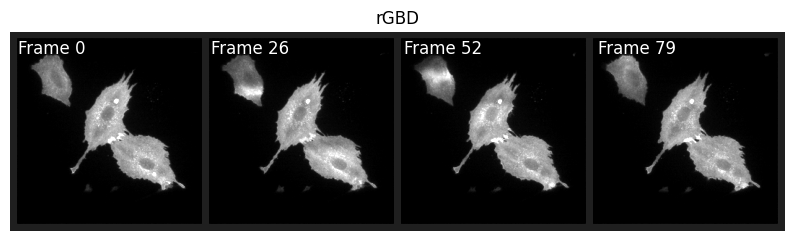

In [8]:
plot_sel_frames(rGBD_binned, 4, "rGBD", (10,3))

In [9]:
rGBD_bckg_rem = remove_image_background(rGBD_binned, 
                                        filter_type='median', 
                                        size=(60,1,1), 
                                        crop_time_axis=False)

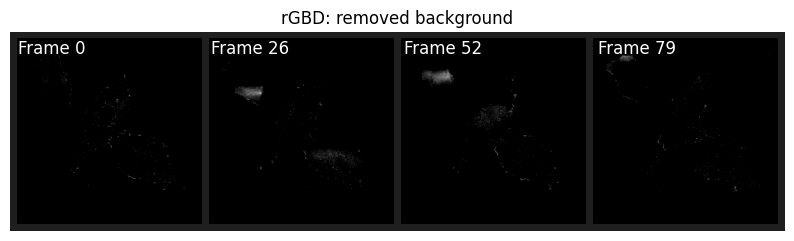

In [11]:
plot_sel_frames(rGBD_bckg_rem, 4, "rGBD: removed background", (10,3))

## Track events

In [12]:
events = track_events_image(rGBD_bckg_rem > 20, eps=8, min_clustersize=150,)

100%|██████████| 80/80 [00:00<00:00, 124.23it/s]


In [13]:
# use skimage rescale to get the events in the original image size
# events_rescaled = np.zeros_like(rGBD)
events_upscaled = transform.rescale(events.astype(int), 
                                    (1, 4, 4), 
                                    order=0, 
                                    preserve_range=True, 
                                    mode='constant')

In [14]:
viewer.add_labels(events_upscaled, name='events')

<Labels layer 'events' at 0x372134fd0>

## Render sample images

In [25]:
arr_sel_frames = np.linspace(0, 60, 4, dtype=int)

rgb_events = []
rgb_rGBD_stim = []
viewer.layers['rGBD'].visible = True
viewer.layers['stim'].visible = True
viewer.layers['events'].visible = True
for img in arr_sel_frames:
    viewer.dims.set_current_step(0, img)
    rgb_events.append(render_as_rgb(viewer, upsample_factor=1))

viewer.layers['events'].visible = False

for img in arr_sel_frames:
    viewer.dims.set_current_step(0, img)
    rgb_rGBD_stim.append(render_as_rgb(viewer, upsample_factor=1))

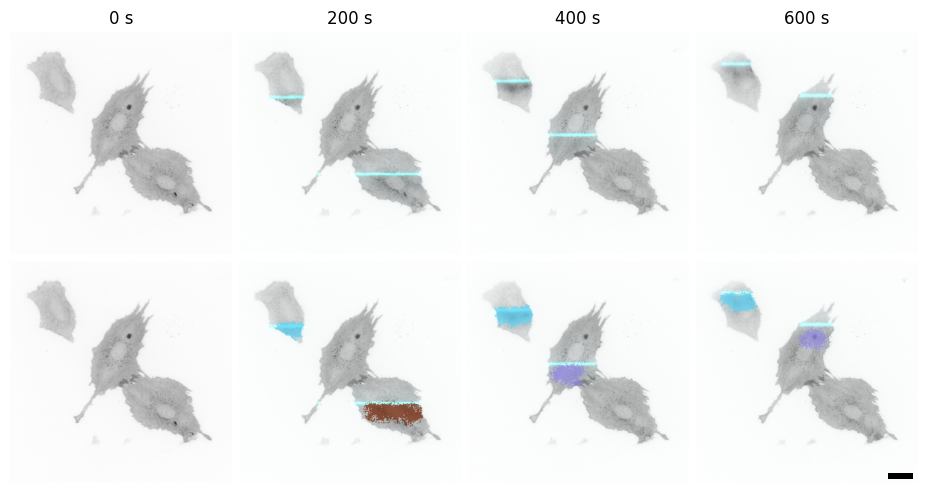

In [26]:
plt.rcParams['svg.fonttype'] = 'none'

fig, ax = plt.subplots(2,4, figsize=(10,5))

for idx, val in enumerate(arr_sel_frames):
    ax[0, idx].imshow(rgb_rGBD_stim[idx])
    ax[0, idx].axis('off')
    ax[0, idx].set_title(f'{val*10} s')

for idx, val in enumerate(arr_sel_frames):
    ax[1, idx].imshow(rgb_events[idx])
    ax[1, idx].axis('off')
    if val == arr_sel_frames[-1]:
        scalebar = ScaleBar(0.21666, "um", length_fraction=0.2, location='lower right', box_alpha=0, scale_loc="none", width_fraction=0.025)
        ax[1, idx].add_artist(scalebar)

plt.tight_layout(h_pad=1, w_pad=-4)
#plt.savefig('../../data/2_synthetic_rhoa_wave/output-plots/montage-sel-frames.png', dpi=600)

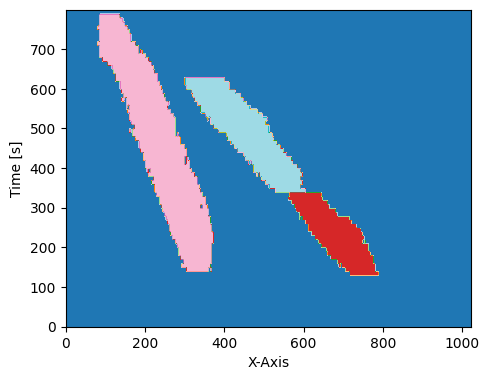

In [27]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
ax.imshow(project_labels(events_upscaled, 2), cmap='tab20', vmin=0, vmax=3)
ax.set_ylabel('Time [s]')
ax.set_xlabel('X-Axis')
ax.invert_yaxis()
plt.tight_layout()

### Save the movie

In [17]:
_stack = render_as_rgb(viewer, axis=0, upsample_factor=1)
io.imsave('plots/stack.tif', _stack)